Dataset and related content taken from Natural Language Processing for Mobile App Privacy Compliance. Peter Story, Sebastian Zimmeck, Abhilasha Ravichander, Daniel Smullen, Ziqi Wang, Joel Reidenberg, N. Cameron Russell, and Norman Sadeh. AAAI Spring Symposium on Privacy Enhancing AI and Language Technologies (PAL 2019), Mar 2019.

Available here – APP350: https://usableprivacy.org/data

EDA should be in the context of my data.  I should state what I expect BEFORE checking for it in the data.

Also at the top I can include links, context, goals

In [2]:
import pandas as pd
from pandas import json_normalize
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm

import sys
from collections import defaultdict
from collections import Counter

import ds_utils_callum
import priv_policy_manipulation_functions as priv_pol_funcs

Put the first policy into a df

## Populating top-level df

In [3]:
all_policies_df = priv_pol_funcs.load_all_policies()
all_policies_df.head(5)

,policy_id,policy_name,policy_type,contains_synthetic,segments
0,1,6677G,TEST,False,"[{'segment_id': 0, 'segment_text': 'PRIVACY PO..."
1,2,AIFactory,TEST,False,"[{'segment_id': 0, 'segment_text': 'AI Factory..."
2,3,AppliqatoSoftware,TEST,False,"[{'segment_id': 0, 'segment_text': 'Automatic ..."
3,4,BandaiNamco,TEST,False,"[{'segment_id': 0, 'segment_text': 'MOBILE APP..."
4,5,BarcodeScanner,TEST,False,"[{'segment_id': 0, 'segment_text': 'Skip to co..."


In [4]:
all_policies_df = priv_pol_funcs.add_metadata_to_policy_df(all_policies_df)
all_policies_df.head(5)

,policy_id,policy_name,policy_type,contains_synthetic,segments,num_segments,num_annotated_segs,total_characters
0,1,6677G,TEST,False,"[{'segment_id': 0, 'segment_text': 'PRIVACY PO...",36,11,12703
1,2,AIFactory,TEST,False,"[{'segment_id': 0, 'segment_text': 'AI Factory...",14,5,5995
2,3,AppliqatoSoftware,TEST,False,"[{'segment_id': 0, 'segment_text': 'Automatic ...",8,1,2450
3,4,BandaiNamco,TEST,False,"[{'segment_id': 0, 'segment_text': 'MOBILE APP...",57,14,32323
4,5,BarcodeScanner,TEST,False,"[{'segment_id': 0, 'segment_text': 'Skip to co...",32,3,6667


# Making segments

Now to make a new dataframe where each row represents a paragraph (segment).

First I will get this to work for a single policy. Then I will loop through all the policies to apply the same manipulation.

In [78]:
def generate_segment_df_2(all_policies_df):
    
    # First create this for a single policy. Then loop through all the policies to apply the same manipulation.
    initial_segment = all_policies_df.loc[0,"segments"]
    initial_segment_df = json_normalize(initial_segment) # normalise it
    initial_segment_df.set_index('segment_id', inplace=True)
    # copy over the policy information
    initial_segment_df["source_policy_number"] = all_policies_df.loc[0,"policy_id"]
    initial_segment_df["policy_type"] = all_policies_df.loc[0,"policy_type"]
    initial_segment_df["contains_synthetic"] = all_policies_df.loc[0,"contains_synthetic"]

    segment_df = initial_segment_df
    
    for i in all_policies_df.index:
        
        this_segment = all_policies_df.loc[i,"segments"]
        this_segment_df = json_normalize(this_segment) # normalise it
        this_segment_df.set_index('segment_id', inplace=True)
        this_segment_df["source_policy_number"] = all_policies_df.loc[i,"policy_id"]
        this_segment_df["policy_type"] = all_policies_df.loc[i,"policy_type"]
        this_segment_df["contains_synthetic"] = all_policies_df.loc[i,"contains_synthetic"]

        segment_df = pd.concat( [segment_df, this_segment_df], axis=0 ) 
    
    # Tidy indexes and columns
    segment_df['policy_segment_id'] = segment_df.index
    segment_df.reset_index(drop=True, inplace=True)
    segment_df.index.names = ['segment_id']
    segment_df = segment_df[['source_policy_number', 'policy_type', 'contains_synthetic', 'policy_segment_id', 'segment_text', 'annotations', 'sentences']]
    
    return segment_df

In [81]:
all_segments_more = generate_segment_df_2(all_policies_df)
all_segments_more['contains_synthetic'].value_counts()

False    8574
True     6969
Name: contains_synthetic, dtype: int64

In [5]:
all_segments_df = priv_pol_funcs.generate_segment_df(all_policies_df)
all_segments_df.head()

,source_policy_number,policy_segment_id,segment_text,annotations,sentences
segment_id,,,,,
0,1,0,PRIVACY POLICY This privacy policy (hereafter ...,[],[]
1,1,1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,[],[]
2,1,2,2. THE INFORMATION WE COLLECT The information ...,[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': 'IP ADDRESS, COOKIES, AND W..."
3,1,3,"2.2 In addition, we store certain information ...",[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': '6677g may use cookies, web..."
4,1,4,(c) to remember your preferences and registrat...,[],[]


In [6]:
all_segments_df.shape

(15543, 5)

In [7]:
all_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15543 entries, 0 to 15542
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_policy_number  15543 non-null  int64 
 1   policy_segment_id     15543 non-null  int64 
 2   segment_text          15543 non-null  object
 3   annotations           15543 non-null  object
 4   sentences             15543 non-null  object
dtypes: int64(2), object(3)
memory usage: 607.3+ KB


# Next step of extraction

I probably want to separate it out to the sentence level, as that is the max granularity of the annotations and some paragraphs are just one sentence anyway.

## Extracting list of practices

Employing my function to get the list of practices from the APP documentation

In [8]:
list_of_practice_groups = priv_pol_funcs.get_list_of_practice_groups()

29 different groups of practices returned, containing 58 individual practices.


In [9]:
# Expand the list of list with a list comprehension
list_of_practices = [practice for practice_group in list_of_practice_groups for practice in practice_group]
print(f"There are {len(list_of_practices)} different practices.")

There are 58 different practices.


In [10]:
list_of_practices[:5]

['Contact_1stParty',
 'Contact_3rdParty',
 'Contact_Address_Book_1stParty',
 'Contact_Address_Book_3rdParty',
 'Contact_City_1stParty']

## Applying all annotations to columns in segment dataframe

In [11]:
segment_annotations = all_segments_df.copy()

annotation_df = pd.DataFrame( data = 0, columns = list_of_practices, index = range(len(all_segments_df)) ) 
# make the list of annotations into columns

segment_annotations = pd.concat([segment_annotations, annotation_df], axis=1) 
# put the columns onto the segment dataframe

print(f"The shape of the segment_annotations dataframe is {segment_annotations.shape}") # Verify

The shape of the segment_annotations dataframe is (15543, 63)


In [12]:
# segment_annotations.head(2) # Verify columns added

In [13]:
for index in range(len(segment_annotations)):
    practices_dictionaries = segment_annotations.loc[index, 'annotations']
    for each_practice in practices_dictionaries:
        segment_annotations.loc[index, each_practice['practice']] += 1

In [14]:
# Verify final row annotated
segment_annotations.iloc[15542,5:].sum()

4

In [15]:
segment_annotations.iloc[:,5:].sum().sum() # Total paragraph annotations

10215

## Investigating rows with multiple of same annotation

In [16]:
# Any paragraphs with more than one of the same annotation?
(segment_annotations.iloc[:,5:].max() == 2)
max_of_each_annotation_per_paragraph = segment_annotations.iloc[:,5:].max()
max_of_each_annotation_per_paragraph.loc[max_of_each_annotation_per_paragraph.values > 1]

Contact_E_Mail_Address_1stParty    2
Location_1stParty                  2
dtype: int64

Two annotations were investigated:
- Contact_E_Mail_Address_1stParty: only applied twice in one paragraph:
    - paragraph 7194: the paragraph mentioned that it both performed AND did not perform this practice.
- Location_1stParty: only applied twice in one paragraph:
    - paragraph 11150: it is a very long paragraph and has the annotation as both performed and not performed. (Note the annotated sentences seem a bit off to be honest.)

## Investigating annotations that occur very rarely

In [17]:
annotation_segment_frequencies = segment_annotations.iloc[:,5:].sum() # Number of paragraphs with each annotation

In [18]:
annotation_segment_frequencies.loc[annotation_segment_frequencies.values < 10]

Contact_City_3rdParty             8
Identifier_IMSI_3rdParty          3
Identifier_SIM_Serial_3rdParty    3
Identifier_SSID_BSSID_3rdParty    2
dtype: int64

Some examples:
- Contact_City_3rdParty: Tends to be describing a level of abstraction/annonimisation of location data
- Identifier_SSID_BSSID_3rdParty: A couple of apps use an advertising service that collects internet network info

## Frequencies of annotations

In [19]:
annotation_segment_frequencies.sort_values(ascending=False)[:10] # top 10 most regularly applied annotations

Contact_E_Mail_Address_1stParty               1111
Identifier_Cookie_or_similar_Tech_1stParty     861
Location_1stParty                              821
Identifier_IP_Address_1stParty                 591
Contact_Phone_Number_1stParty                  565
Identifier_Cookie_or_similar_Tech_3rdParty     525
Identifier_Device_ID_1stParty                  446
Contact_Postal_Address_1stParty                364
SSO                                            274
Demographic_Age_1stParty                       260
dtype: int64

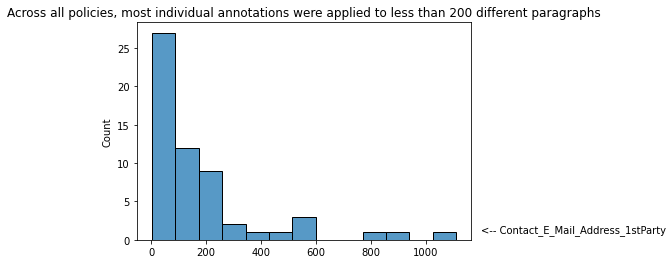

In [20]:
plt.figure()
# plt.hist(annotation_segment_frequencies, bins=20)
plt.title("Across all policies, most individual annotations were applied to less than 200 different paragraphs")

sns.histplot(annotation_segment_frequencies)
plt.text(1200, 1, "<-- Contact_E_Mail_Address_1stParty")
plt.show()

Contact email, cookies and location were the annotations applied to the greatest number of paragraphs.

## Break down to sentence level

Will probably have to use similar code / sequence to how I broke it down into paragraphs.  Most heavy work is in the Segment_text and Sentences columns.  Would be good to know how to split the sentences – colons, semi-colons, full stops etc.  One way I can find the endings is by looking at all the "Sentences" and find the final characters of all the sentence texts.  Then I can split the segment_text using those.

In [42]:
segment_annotations.head(3)

,source_policy_number,policy_segment_id,segment_text,annotations,sentences,Contact_1stParty,Contact_3rdParty,Contact_Address_Book_1stParty,Contact_Address_Book_3rdParty,Contact_City_1stParty,...,Location_Bluetooth_1stParty,Location_Bluetooth_3rdParty,Location_Cell_Tower_1stParty,Location_Cell_Tower_3rdParty,Location_GPS_1stParty,Location_GPS_3rdParty,Location_IP_Address_1stParty,Location_IP_Address_3rdParty,Location_WiFi_1stParty,Location_WiFi_3rdParty
0,1,0,PRIVACY POLICY This privacy policy (hereafter ...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,2. THE INFORMATION WE COLLECT The information ...,[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': 'IP ADDRESS, COOKIES, AND W...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
segment_annotations.loc[2, 'segment_text']

"2. THE INFORMATION WE COLLECT The information that our products collect includes (among others) the following: A) IP ADDRESS, COOKIES, AND WEB BEACONS 2.1 When you visit our products, our servers automatically save your computer's IP address. IP addresses will be collected, along with information about the actual web pages that you visit on our products. If you arrive at our products via a link from another product, the URL of the linking product and the URL of any product that you link to next will also be collected."

In [46]:
annotated_sentences = []

for row in range(len(segment_annotations)):
    
    sentences_list = segment_annotations.loc[row, 'sentences']

    for i in range(len(sentences_list)):
        annotated_sentences.append(sentences_list[i]['sentence_text'])
        
len(annotated_sentences)

8394

In [77]:
annotated_sentences[5]

"A cookie is a piece of data stored on the user's computer and is tied to information about the user."

In [20]:
segment_annotations

,source_policy_number,policy_segment_id,segment_text,annotations,sentences,Contact_1stParty,Contact_3rdParty,Contact_Address_Book_1stParty,Contact_Address_Book_3rdParty,Contact_City_1stParty,...,Location_Bluetooth_1stParty,Location_Bluetooth_3rdParty,Location_Cell_Tower_1stParty,Location_Cell_Tower_3rdParty,Location_GPS_1stParty,Location_GPS_3rdParty,Location_IP_Address_1stParty,Location_IP_Address_3rdParty,Location_WiFi_1stParty,Location_WiFi_3rdParty
0,1,0,PRIVACY POLICY This privacy policy (hereafter ...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,2. THE INFORMATION WE COLLECT The information ...,[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': 'IP ADDRESS, COOKIES, AND W...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,"2.2 In addition, we store certain information ...",[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': '6677g may use cookies, web...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,(c) to remember your preferences and registrat...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15538,350,97,"699 8th Street San Francisco, CA 94103 back to...",[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15539,350,98,Facebook Twitter YouTube Instagram NaturalMoti...,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15540,350,99,©2017 Zynga Inc. All rights reserved.,[],[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15541,350,100,We and the service providers acting on our beh...,[{'practice': 'Identifier_Cookie_or_similar_Te...,[{'sentence_text': 'We and the service provide...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Demo EDA